In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 9.8 MB 27.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [44]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
import statsmodels.api as sm
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima # for determining ARIMA orders  
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller

In [47]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')
df.head()

,Date,SalesVolume
0,1995-01-01,47639
1,1995-02-01,47880
2,1995-03-01,67025
3,1995-04-01,56925
4,1995-05-01,64192


In [48]:
len(df)

320

In [49]:
df = df.dropna()
df['Date'] = pd.DatetimeIndex(df['Date'])
df = df.groupby('Date').sum()
#Settting a Monthly frequency and also to the first day of the month
df = df.asfreq('MS')

In [50]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

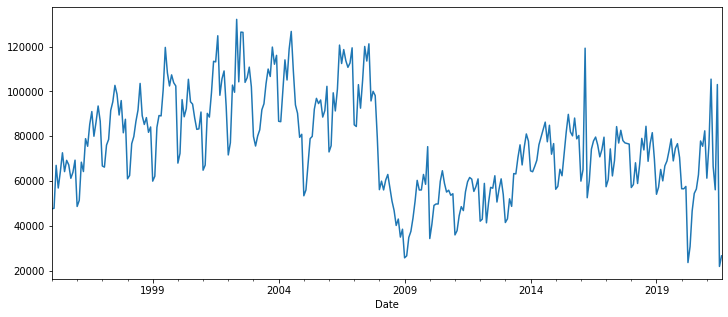

In [51]:
df['SalesVolume'].plot(figsize=(12,5));

In [53]:
viz_df = df[['SalesVolume']]
viz_df = viz_df.dropna()

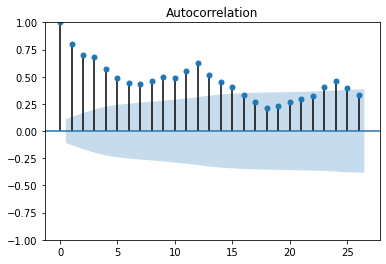

In [55]:
#ACF Plot
plot_acf(viz_df)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


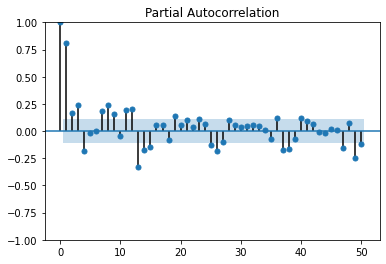

In [54]:
#PACF Plot
plot_pacf(viz_df, lags=50)
pyplot.show()

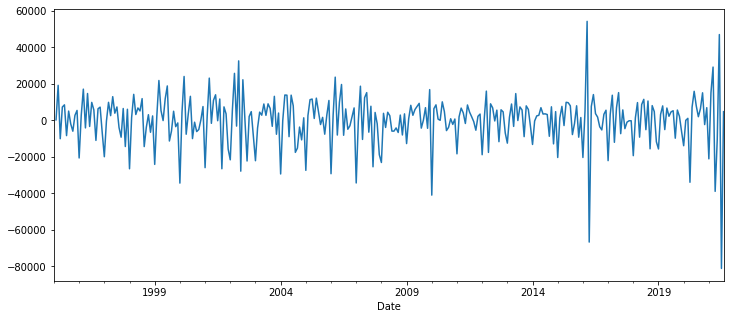

In [56]:
#First order differencing
df['d1'] = diff(df['SalesVolume'],k_diff=1)
df['d1'].plot(figsize=(12,5));

In [57]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.328886
p-value                   0.000005
# lags used              17.000000
# observations          301.000000
critical value (1%)      -3.452263
critical value (5%)      -2.871191
critical value (10%)     -2.571912
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [58]:
viz_df = df[['d1']]
viz_df = viz_df.dropna()

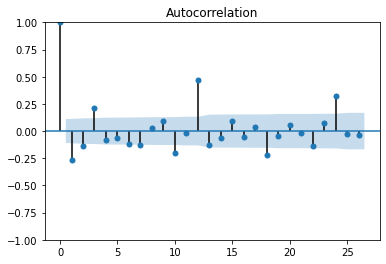

In [60]:
#ACF Plot
plot_acf(viz_df)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


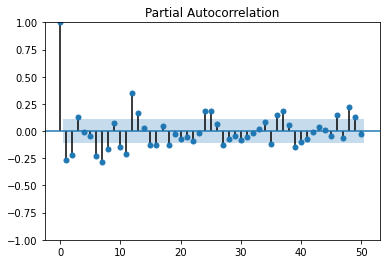

In [62]:
#PACF Plot
plot_pacf(viz_df, lags=50)
pyplot.show()

In [63]:
df = df.iloc[1:,:]

In [64]:
auto_arima(df['d1'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  319
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -3428.174
Date:                Tue, 21 Dec 2021   AIC                           6870.348
Time:                        12:18:32   BIC                           6896.704
Sample:                             0   HQIC                          6880.873
                                - 319                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1807      0.041     28.641      0.000       1.100       1.261
ar.L2         -0.5272      0.071     -7.445      0.000      -0.666      -0.388
ar.L3          0.2786      0.091      3.068      0.002       0.101       0.456
ar.L4         -0.4738      0.057     -8.319      0.000      -0.585      -0.362
ma.L1         -1.6757      0.027    -61.639      0.000      -1.729      -1.622
ma.L2          0.9627      0.030     32.518      0.000       0.905       1.021
sigma2      1.511e+08   2.75e-10    5.5e+17      0.000    1.51e+08    1.51e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               309.76
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.58
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+33. Standard errors may be unstable.
"""

In [65]:
# Set one month for testing
train = df.iloc[:305]
test = df.iloc[305:]

In [77]:
model=sm.tsa.statespace.SARIMAX(df['d1'],order=(4, 0, 2))
results=model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     d1   No. Observations:                  319
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -3428.174
Date:                Tue, 21 Dec 2021   AIC                           6870.348
Time:                        12:21:07   BIC                           6896.704
Sample:                    02-01-1995   HQIC                          6880.873
                         - 08-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1807      0.041     28.641      0.000       1.100       1.261
ar.L2         -0.5272      0.071     -7.445      0.000      -0.666      -0.388
ar.L3          0.2786      0.091      3.068      0.002       0.101       0.456
ar.L4         -0.4738      0.057     -8.319      0.000      -0.585      -0.362
ma.L1         -1.6757      0.027    -61.639      0.000      -1.729      -1.622
ma.L2          0.9627      0.030     32.518      0.000       0.905       1.021
sigma2      1.511e+08   2.75e-10    5.5e+17      0.000    1.51e+08    1.51e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               309.76
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                            -0.58
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+33. Standard errors may be unstable.
"""

In [88]:
start=len(train)
end=len(train)+len(test)-1
predictions_SARIMAX = results.predict(start=start, end=end).rename('SARIMAX(4, 0, 2) Predictions')

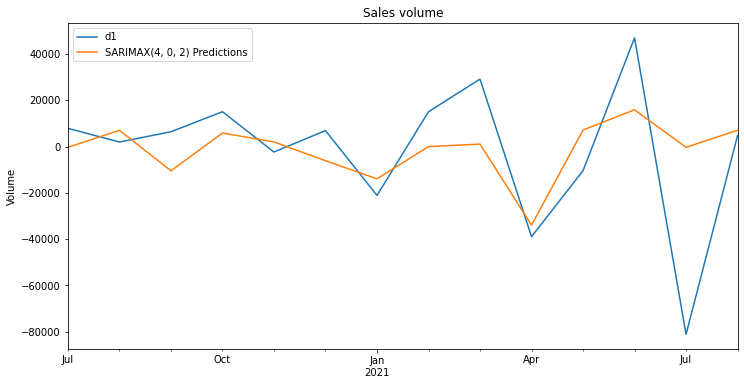

In [89]:
title = 'Sales volume'
ylabel='Volume'
xlabel='' # we don't really need a label here

ax = test['d1'].plot(legend=True,figsize=(12,6),title=title)
predictions_SARIMAX.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [80]:
model = ARIMA(train['d1'],  order=(1, 0, 0),  seasonal_order=(0, 1, 0, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                               d1   No. Observations:                  305
Model:             ARIMA(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -3130.594
Date:                          Tue, 21 Dec 2021   AIC                           6265.187
Time:                                  12:21:18   BIC                           6272.547
Sample:                              02-01-1995   HQIC                          6268.135
                                   - 06-01-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3612      0.030    -12.087      0.000      -0.420      -0.303
sigma2       1.12e+08   5.33e-11    2.1e+18      0.000    1.12e+08    1.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):               197.52
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.44
Prob(H) (two-sided):                  0.12   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.28e+33. Standard errors may be unstable.
"""

In [90]:
start=len(train)
end=len(train)+len(test)-1
predictions_ARIMA = results.predict(start=start, end=end).rename('ARIMA(1, 0, 0)x(0, 1, 0, 12) Predictions')

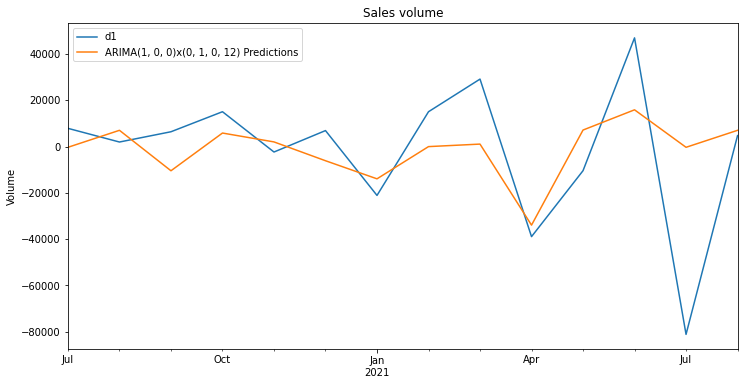

In [91]:
title = 'Sales volume'
ylabel='Volume'
xlabel='' # we don't really need a label here

ax = test['d1'].plot(legend=True,figsize=(12,6),title=title)
predictions_ARIMA.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [85]:
def metrics(model,test,predictions):
  print(f'{model} MAPE Error:',  mean_absolute_percentage_error(test['d1'], predictions))
  print(f'{model} MSE Error: ',mean_squared_error(test['SalesVolume'], predictions))
  print(f'{model} RMSE Error: ',rmse(test['SalesVolume'], predictions))
  print(f'{model} MAE Error: ',mean_absolute_error(test['SalesVolume'], predictions))

In [86]:
metrics('SARIMAX(4, 0, 2)',test,predictions_SARIMAX)

SARIMAX(4, 0, 2) MAPE Error: 1.6767150438390648
SARIMAX(4, 0, 2) MSE Error:  5231660746.81268
SARIMAX(4, 0, 2) RMSE Error:  72330.22014906826
SARIMAX(4, 0, 2) MAE Error:  67927.83282585567


In [87]:
metrics('ARIMA(1, 0, 0)x(0, 1, 0, 12)	',test,predictions_ARIMA)

ARIMA(1, 0, 0)x(0, 1, 0, 12)	 MAPE Error: 1.2052704304454633
ARIMA(1, 0, 0)x(0, 1, 0, 12)	 MSE Error:  5191481879.744655
ARIMA(1, 0, 0)x(0, 1, 0, 12)	 RMSE Error:  72051.93876464848
ARIMA(1, 0, 0)x(0, 1, 0, 12)	 MAE Error:  67612.55413015925
